In [67]:
import os
import numpy as np
import pandas as pd
pd.set_option('max_rows',1000)
pd.set_option('display.max_colwidth',-1)
pd.set_option('display.expand_frame_repr', False)

In [68]:
datadir='/Users/cjyang/Downloads/DLcomp/NEW/mlperf-deepcam'
tagdirs=[x for x in os.listdir(datadir) if x.startswith('PT-fp')]
tagdirs.sort()
# print(tagdirs)
dfcs={}

for i,tagdir in enumerate(tagdirs):
    tagd=os.path.join(datadir,tagdir)
    files=os.listdir(tagd)
    tag='-'.join(tagdir.split('-')[1:5])
#     print(tag)
    
    filess=[os.path.join(tagd,file) for file in files if 'out.' in file]
    print('{} files from {}'.format(len(filess),tagd))
    cntf=0
    dfmetric=pd.DataFrame()
    dfcs[tag]=pd.DataFrame()
    dftmp=pd.DataFrame()
    
    
    for file in filess:
        dft=pd.DataFrame()
        cntf+=1
        with open(file,'r') as f:
            cnt=0
            while True:
                ln=f.readline()
                if not ln:
                    break
                cnt+=1
                if 'Host Name' in ln:
                    break
            df = pd.read_csv(file, skiprows=cnt-1)
            if cntf != 1:
                newdfg=df.groupby(['Kernel Name']).sum()
                dft[df['Metric Name'][0]]=newdfg['Metric Value']
                dfmetric=pd.merge(dfmetric, dft,left_index=True,right_index=True)
            else:
                dftmp=df
                newdfg=df.groupby(['Kernel Name']).sum()
                dfmetric[df['Metric Name'][0]]=newdfg['Metric Value']
                dfmetric['Count']=df.groupby(['Kernel Name']).count()['ID']

    dfmetric['Time']=dfmetric['sm__cycles_elapsed.avg'] \
                    / (dfmetric['sm__cycles_elapsed.avg.per_second'] /dfmetric['Count'] )

    dfmetric['CC FLOPs']= 2 * dfmetric['sm__sass_thread_inst_executed_op_hfma_pred_on.sum'] \
                        + dfmetric['sm__sass_thread_inst_executed_op_hmul_pred_on.sum'] \
                        + dfmetric['sm__sass_thread_inst_executed_op_hadd_pred_on.sum'] \
                        + 2 * dfmetric['sm__sass_thread_inst_executed_op_ffma_pred_on.sum'] \
                        + dfmetric['sm__sass_thread_inst_executed_op_fmul_pred_on.sum'] \
                        + dfmetric['sm__sass_thread_inst_executed_op_fadd_pred_on.sum'] 

    dfmetric['TC FLOPs']= 512 * dfmetric['sm__inst_executed_pipe_tensor.sum']

    dfmetric['all FLOPs']= dfmetric['CC FLOPs'] + dfmetric['TC FLOPs']

    dfmetric['AI HBM'] = dfmetric['all FLOPs'].div(dfmetric['dram__bytes.sum'])
    dfmetric['AI L2'] = dfmetric['all FLOPs'].div(dfmetric['lts__t_bytes.sum'])
    dfmetric['AI L1'] = dfmetric['all FLOPs'].div(dfmetric['l1tex__t_bytes.sum'])

    dfmetric['GFLOP/s'] = dfmetric['all FLOPs']/ dfmetric['Time'] /1024/1024/1024
    dfmetric['TC GFLOP/s'] = dfmetric['TC FLOPs']/ dfmetric['Time'] /1024/1024/1024

#     dfmetric.to_csv(tag+'.csv')

    dfcs[tag]=pd.concat([dfcs[tag],dfmetric])
    print('\twith shape {}: {:4d} kernels (grouped by name) \
and {:3d} metrics (both raw and derived)'.format(dfcs[tag].shape,\
                                                 dfcs[tag].shape[0],
                                                 dfcs[tag].shape[1]))
    
print('--------------')
print('All {} directories (fw, bw and opt) have been read in to dfcs with tags: \n{}'\
      .format(len(list(dfcs.keys())),list(dfcs.keys())))


12 files from /Users/cjyang/Downloads/DLcomp/NEW/mlperf-deepcam/PT-fp32-O0-Adam-bw-732898
	with shape (54, 22):   54 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from /Users/cjyang/Downloads/DLcomp/NEW/mlperf-deepcam/PT-fp32-O0-Adam-fw-733726
	with shape (35, 22):   35 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from /Users/cjyang/Downloads/DLcomp/NEW/mlperf-deepcam/PT-fp32-O0-Adam-opt-732900
	with shape (7, 22):    7 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from /Users/cjyang/Downloads/DLcomp/NEW/mlperf-deepcam/PT-fp32-O1-Adam-bw-733727
	with shape (70, 22):   70 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from /Users/cjyang/Downloads/DLcomp/NEW/mlperf-deepcam/PT-fp32-O1-Adam-fw-733728
	with shape (45, 22):   45 kernels (grouped by name) and  22 metrics (both raw and derived)
12 files from /Users/cjyang/Downloads/DLcomp/NEW/mlperf-deepcam/PT-fp32-O1-Adam-opt-733729

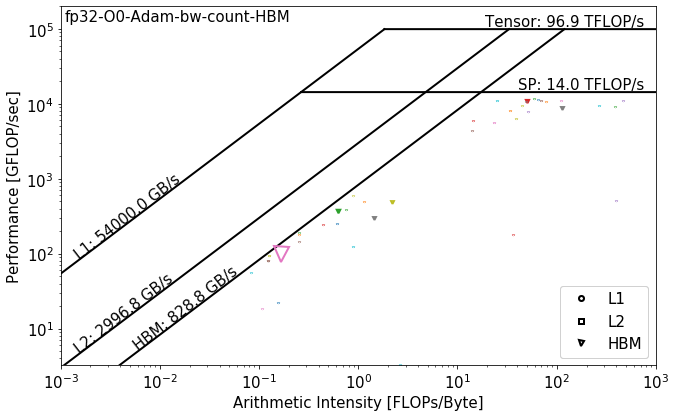

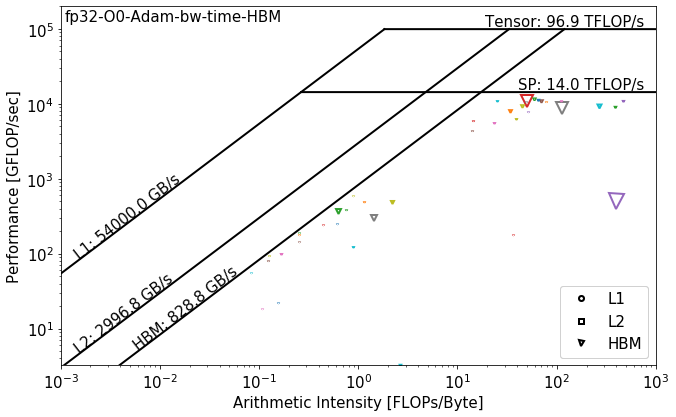

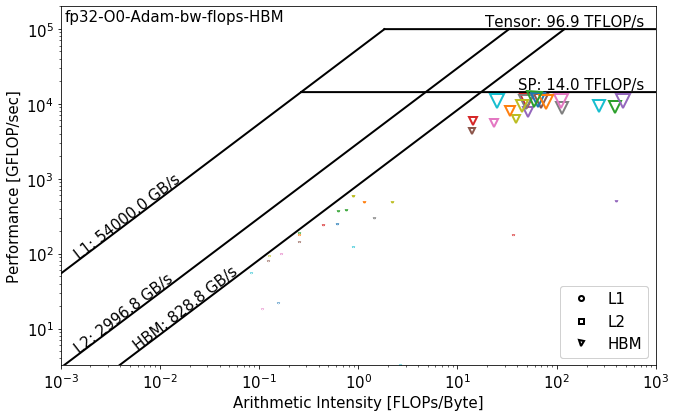

FLOPS are all 0s!


In [96]:
# from plotRoofline import roofline
tags=dfcs.keys()
tags=['fp32-O0-Adam-bw']
flag='HBM'

for tag in tags:
    dfm=dfcs[tag]
    LABELS = []
    AIL1   = dfm['AI L1'].tolist()
    AIL2   = dfm['AI L2'].tolist()
    AIHBM  = dfm['AI HBM'].tolist()
    FLOPS  = dfm['GFLOP/s'].tolist()
    TCFLOPS  = dfm['TC GFLOP/s'].tolist()
    COUNT  = dfm['Count'].tolist()
    TIME   = dfm['Time'].tolist()

    roofline(tag+'-count', flag, FLOPS, AIHBM, AIL2, AIL1, LABELS, COUNT)
    roofline(tag+'-time', flag, FLOPS, AIHBM, AIL2, AIL1, LABELS, TIME)
    roofline(tag+'-flops', flag, FLOPS, AIHBM, AIL2, AIL1, LABELS, FLOPS)
    roofline(tag+'-tcflops', flag, TCFLOPS, AIHBM, AIL2, AIL1, LABELS, TCFLOPS)



In [102]:
# All dataframes
tags = dfcs.keys() 

for tag in tags:
    dfm=dfcs[tag]
    print('{:20}: {:5d} out of {:5d} for {:.2f}s, {:2.2%} of total {:.2f}s'.format(tag,\
                                dfm[dfm['GFLOP/s']==0]['Count'].sum(),dfm['Count'].sum(),\
                                dfm[dfm['GFLOP/s']==0]['Time'].sum(),\
                                dfm[dfm['GFLOP/s']==0]['Time'].sum()/dfm['Time'].sum(), dfm['Time'].sum()))


fp32-O0-Adam-bw     :   689 out of  1424 for 0.02s, 6.09% of total 0.40s
fp32-O0-Adam-fw     :   363 out of   633 for 0.02s, 11.30% of total 0.17s
fp32-O0-Adam-opt    :     0 out of  2709 for 0.00s, 0.00% of total 0.02s
fp32-O1-Adam-bw     :   609 out of  1575 for 0.01s, 5.20% of total 0.23s
fp32-O1-Adam-fw     :   437 out of   797 for 0.01s, 10.14% of total 0.10s
fp32-O1-Adam-opt    :     0 out of  2709 for 0.00s, 0.00% of total 0.02s
fp32-O1-AdamW-bw    :   609 out of  1575 for 0.01s, 5.20% of total 0.23s
fp32-O1-AdamW-fw    :   437 out of   797 for 0.01s, 10.16% of total 0.10s
fp32-O1-AdamW-opt   :     0 out of  2709 for 0.00s, 0.00% of total 0.02s
fp32-O1-LAMB-bw     :   308 out of  1273 for 0.01s, 4.69% of total 0.23s
fp32-O1-LAMB-fw     :   437 out of   797 for 0.01s, 10.15% of total 0.10s
fp32-O1-LAMB-opt    :     5 out of    35 for 0.00s, 0.39% of total 0.00s
fp32-O2-Adam-bw     :   605 out of  1426 for 0.01s, 5.04% of total 0.23s
fp32-O2-Adam-fw     :   290 out of   644 for 0.

In [94]:

# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches

# font = { 'size'   : 15}
# plt.rc('font', **font)

# colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
# styles = ['o','s','v','^','D',">","<","*","h","H","+","1","2","3","4","8","p","d","|","_",".",","]

# def roofline(tag, flag, FLOPS, AIHBM, AIL2=None, AIL1=None, LABELS=None, NormDim=None):

#     if not FLOPS:
#         print('FLOPS can not be empty!')
#         return
#     if max(FLOPS)==0:
#         print('FLOPS are all 0s!')
#         return
#     if (not AIHBM) and (not AIL2) and (not AIL1):
#         print('AIHBM, AIL2 and AIL1 can not all be empty!')
#         return
#     if (len(FLOPS) != len(AIHBM)) or (len(FLOPS) != len(AIL2)) or (len(FLOPS) != len(AIL1)):
#         print('FLOPS needs to have the same length as AI!')
#         return
#     if (flag != 'HBM') and (flag != 'L2') and (flag != 'L1') and (flag != 'all'):
#         print('flag needs to be one of HBM, L2, L1, and all!')
#         return
#     if NormDim:
#         tmp= np.array(NormDim)
#         tmpp=tmp[np.nonzero(FLOPS)]
#         markersize = np.array(NormDim)/max(tmpp)*15
#     else:
#         markersize  = np.ones(len(NormDim))*5
#     base_markersize = 5
#     markerwidth = 2

#     memRoofs = [('L1', 54000.), ('L2', 2996.77), ('HBM', 828.76)] #('L1', 14336.)
# #     cmpRoofs = [('Tensor', 125000), ('FMA', 7068.86), ('No-FMA', 3535.79)]
#     cmpRoofs = [('Tensor', 96.9), ('SP', 14.0)]

#     fig = plt.figure(1,figsize=(10.67,6.6))
#     plt.clf()
#     ax = fig.gca()
#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     ax.set_xlabel('Arithmetic Intensity [FLOPs/Byte]')
#     ax.set_ylabel('Performance [GFLOP/sec]')

#     nx   = 10000
#     xmin = -3 #-0.65
#     xmax = 3
#     ymin = 0.001
#     ymax = 200000

#     tmp= np.array(FLOPS)
#     tmpp=tmp[np.nonzero(FLOPS)]
#     ymin = 1 if tmpp.min()<1 else tmpp.min()
# #     ymax = tmpp.max()
# #     xmax = np.log10(max(AIHBM))
    
#     ax.set_xlim(10**xmin, 10**xmax)
#     ax.set_ylim(ymin, ymax)

#     ixx = int(nx*0.02)
#     xlim = ax.get_xlim()
#     ylim = ax.get_ylim()

#     scomp_x_elbow  = []
#     scomp_ix_elbow = []
#     smem_x_elbow   = []
#     smem_ix_elbow  = []

#     x = np.logspace(xmin,xmax,nx)
#     for roof in cmpRoofs:
#         for ix in range(1,nx):
#             if float(memRoofs[0][1] * x[ix]) >= roof[1]*1024 and (memRoofs[0][1] * x[ix-1]) < roof[1]*1024:
#                 scomp_x_elbow.append(x[ix-1])
#                 scomp_ix_elbow.append(ix-1)
#                 break


#     for roof in memRoofs:
#         for ix in range(1,nx):
#             if (cmpRoofs[0][1]*1024 <= roof[1] * x[ix] and cmpRoofs[0][1]*1024 > roof[1] * x[ix-1]):
#                 smem_x_elbow.append(x[ix-1])
#                 smem_ix_elbow.append(ix-1)
#                 break

#     for i in range(len(cmpRoofs)):
#         roof = cmpRoofs[i][1]*1024
#         y = np.ones(len(x)) * roof
#         ax.plot(x[scomp_ix_elbow[i]:],y[scomp_ix_elbow[i]:],c='k',ls='-',lw='2')

#     for i in range(len(memRoofs)):
#         roof = memRoofs[i][1]
#         y = x * roof
#         ax.plot(x[:smem_ix_elbow[i]+1],y[:smem_ix_elbow[i]+1],c='k',ls='-',lw='2')

#     marker_handles = []  

#     for i in range(len(AIHBM)):
#         if flag == 'L1':
#             ax.plot(float(AIL1[i]),float(FLOPS[i]),c=colors[i%10],marker=styles[0],\
#                     linestyle='None',ms=markersize[i],markerfacecolor='none',\
#                     markeredgewidth=markerwidth)#,label=LABELS[i])
#         elif flag == 'L2':
#             ax.plot(float(AIL2[i]),float(FLOPS[i]),c=colors[i%10],marker=styles[1],\
#                     linestyle='None',ms=markersize[i],markerfacecolor='none',\
#                     markeredgewidth=markerwidth)#,label=LABELS[i])
#         elif flag == 'HBM':
#             ax.plot(float(AIHBM[i]),float(FLOPS[i]),c=colors[i%10],marker=styles[2],\
#                     linestyle='None',ms=markersize[i],markerfacecolor='none',\
#                     markeredgewidth=markerwidth)#,label=LABELS[i])
#         elif flag == 'all':
#             ax.plot(float(AIL1[i]),float(FLOPS[i]),c=colors[0],marker=styles[0],linestyle='None',\
#                     ms=markersize[i],markerfacecolor='none',markeredgewidth=markerwidth)#,label=LABELS[i])
#             ax.plot(float(AIL2[i]),float(FLOPS[i]),c=colors[1],marker=styles[1],linestyle='None',\
#                     ms=markersize[i],markerfacecolor='none',markeredgewidth=markerwidth)#,label=LABELS[i])
#             ax.plot(float(AIHBM[i]),float(FLOPS[i]),c=colors[2],marker=styles[2],linestyle='None',
#                     ms=markersize[i],markerfacecolor='none',markeredgewidth=markerwidth)#,label=LABELS[i])


            
#     for i in range(len(memRoofs)):
# #         marker_handles.append(ax.plot([],[],c='k',marker=styles[i],linestyle='None',ms=np.mean(markersize),\
#         marker_handles.append(ax.plot([],[],c='k',marker=styles[i],linestyle='None',ms=base_markersize,\
#                                       markerfacecolor='none',markeredgewidth=markerwidth,label=memRoofs[i][0])[0])

#     for roof in cmpRoofs:
#         ax.text(x[-ixx],roof[1]*1024,
#               roof[0] + ': ' + '{0:.1f}'.format(roof[1]) + ' TFLOP/s',
#               horizontalalignment='right',
#               verticalalignment='bottom')

#     for roof in memRoofs:
#         ang = np.arctan(np.log10(xlim[1]/xlim[0]) / np.log10(ylim[1]/ylim[0])
#                                    * fig.get_size_inches()[1]/fig.get_size_inches()[0] )
#         if x[ixx]*roof[1] >ymin:
#             ax.text(x[ixx],x[ixx]*roof[1]*(1+0.25*np.sin(ang)**2),
#               roof[0] + ': ' + '{0:.1f}'.format(float(roof[1])) + ' GB/s',
#               horizontalalignment='left',
#               verticalalignment='bottom',
#               rotation=180/np.pi*ang)
#         else:
#             ymin_ix_elbow=list()
#             ymin_x_elbow=list()
#             for ix in range(1,nx):
#                 if (ymin <= roof[1] * x[ix] and ymin > roof[1] * x[ix-1]):
#                     ymin_x_elbow.append(x[ix-1])
#                     ymin_ix_elbow.append(ix-1)
#                     break
#             ax.text(x[ixx+ymin_ix_elbow[0]],x[ixx+ymin_ix_elbow[0]]*roof[1]*(1+0.25*np.sin(ang)**2),
#               roof[0] + ': ' + '{0:.1f}'.format(float(roof[1])) + ' GB/s',
#               horizontalalignment='left',
#               verticalalignment='bottom',
#               rotation=180/np.pi*ang)



#     leg1 = plt.legend(handles = marker_handles,loc='lower right', ncol=1,bbox_to_anchor = (1,0))
#     ax.add_artist(leg1)

#     #   patch_handles = list()
#     #   for i in range(0,len(AIHBM)):
#     #       patch_handles.append(mpatches.Patch(color=colors[i%10]))#,label = LABELS[i]))

#     #   leg2 = plt.legend(handles = patch_handles,loc=4,ncol=2,bbox_to_anchor = (1,0),scatterpoints = 1)

#     ax.text(xlim[0]*1.1,ylim[1]/1.1, '-'.join([tag,flag]), horizontalalignment='left',verticalalignment='top')

# #     plt.savefig(tag+'.png')
# #     plt.savefig(tag+'.eps')

#     plt.show()